In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import textwrap

In [2]:
global_metadata = pd.read_csv('../../src/nlp/topic_modeling/topic_data.csv')
community_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/community_topic_counts.csv')
hub_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/hub_topic_counts.csv')
bridge_topic_counts = pd.read_csv('../../src/nlp/topic_modeling/bridge_topic_counts.csv')
top_n_topics = pd.read_csv('../../src/nlp/topic_modeling/top_n_topics.csv')
roles = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')

In [3]:
global_metadata.head()

,author,id,type,topic,topic_id
0,Raichu4u,1mv3z5n,post,54_disappearances_apathy_abuses_apathetic,54
1,KingGhidorah1225,1musrfu,post,58_speech_tendencies_suppression_hierarchy,58
2,Potato_Cat93,1mujuir,post,14_democrats_republicans_election_dems,14
3,Rong_Liu,1mumwdb,post,27_authoritarianism_democratic_democracies_aut...,27
4,Candle-Jolly,1mun37m,post,7_democrats_republicans_biden_obama,7


In [4]:
communities_info = roles[['community_id', 'community_type']].drop_duplicates()

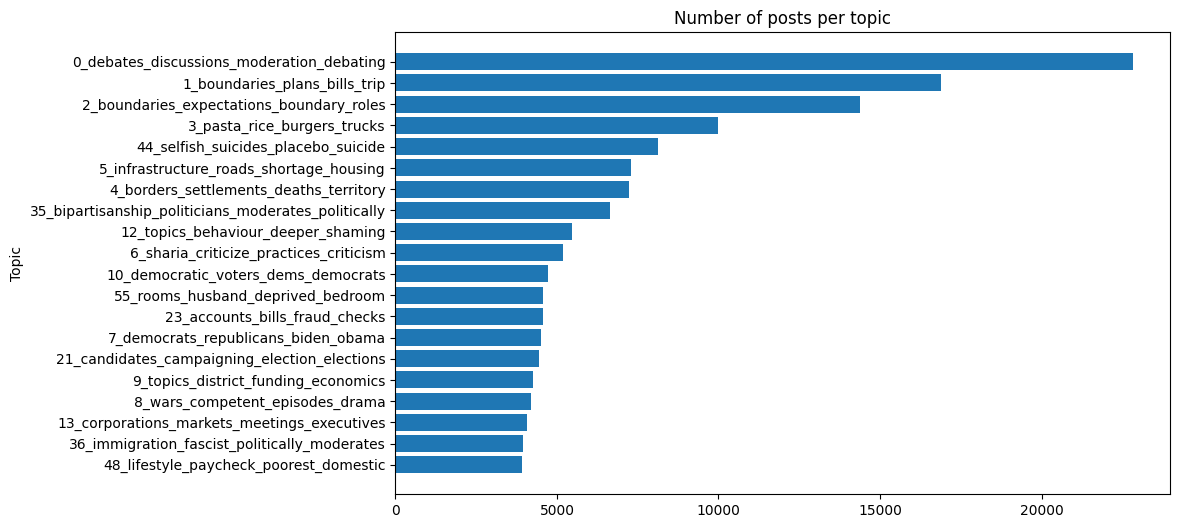

In [5]:
topic_counts = global_metadata['topic'].value_counts().reset_index().head(20)
topic_counts.columns = ['topic', 'count']

plt.figure(figsize=(10,6))
plt.barh(topic_counts['topic'], topic_counts['count'])
plt.ylabel("Topic")
plt.title("Number of posts per topic")
plt.gca().invert_yaxis()
plt.show()

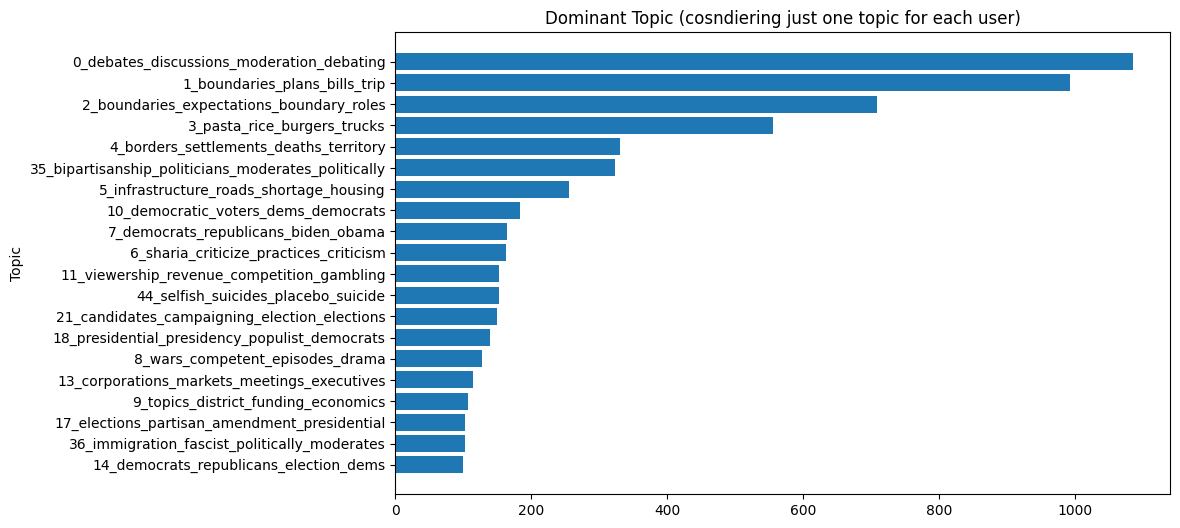

In [36]:
# Defining dominant topic for each user
user_top_topic = (global_metadata
                  .groupby(['author', 'topic'])
                  .size() 
                  .reset_index(name='count'))

# Trova il topic con il massimo numero di post per utente
user_top_topic = user_top_topic.loc[user_top_topic.groupby('author')['count'].idxmax()]

# 2. Conta quante volte ciascun topic è predominante
top_topic_counts = user_top_topic['topic'].value_counts().reset_index().head(20)
top_topic_counts.columns = ['topic', 'count']

# 3. Visualizza
plt.figure(figsize=(10,6))
plt.barh(top_topic_counts['topic'], top_topic_counts['count'])
plt.ylabel("Topic")
plt.title("Dominant Topic (cosndiering just one topic for each user)")
plt.gca().invert_yaxis()
plt.show()

In [6]:
# Unisci le informazioni sulla tipologia di community
community_topic_counts_with_type = community_topic_counts.merge(
    communities_info, 
    on='community_id', 
    how='left'
)

# Aggiungi la tipologia anche ai top_n_topics
top_n_topics_with_type = top_n_topics.merge(
    communities_info[['community_id', 'community_type']], 
    on='community_id', 
    how='left'
)

In [15]:
community_topic_counts_with_type.head()

,community_id,topic,topic_id,count,percent,community_type
0,0,0_debates_discussions_moderation_debating,0,10894,0.096193,Very Strong community
1,0,10_democratic_voters_dems_democrats,10,3722,0.032865,Very Strong community
2,0,11_viewership_revenue_competition_gambling,11,1137,0.010040,Very Strong community
3,0,12_topics_behaviour_deeper_shaming,12,2181,0.019258,Very Strong community
4,0,13_corporations_markets_meetings_executives,13,2169,0.019152,Very Strong community


In [16]:
top_n_topics_with_type.head()

,community_id,topic,topic_id,count,percent,community_type
0,0,0_debates_discussions_moderation_debating,0,10894,0.096193,Very Strong community
1,0,2_boundaries_expectations_boundary_roles,2,10250,0.090507,Very Strong community
2,0,4_borders_settlements_deaths_territory,4,6058,0.053492,Very Strong community
3,0,44_selfish_suicides_placebo_suicide,44,4642,0.040989,Very Strong community
4,0,6_sharia_criticize_practices_criticism,6,3995,0.035276,Very Strong community


/tmp/ipykernel_5308/2526586371.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_topics_by_type = topic_freq_by_type.groupby('community_type').apply(


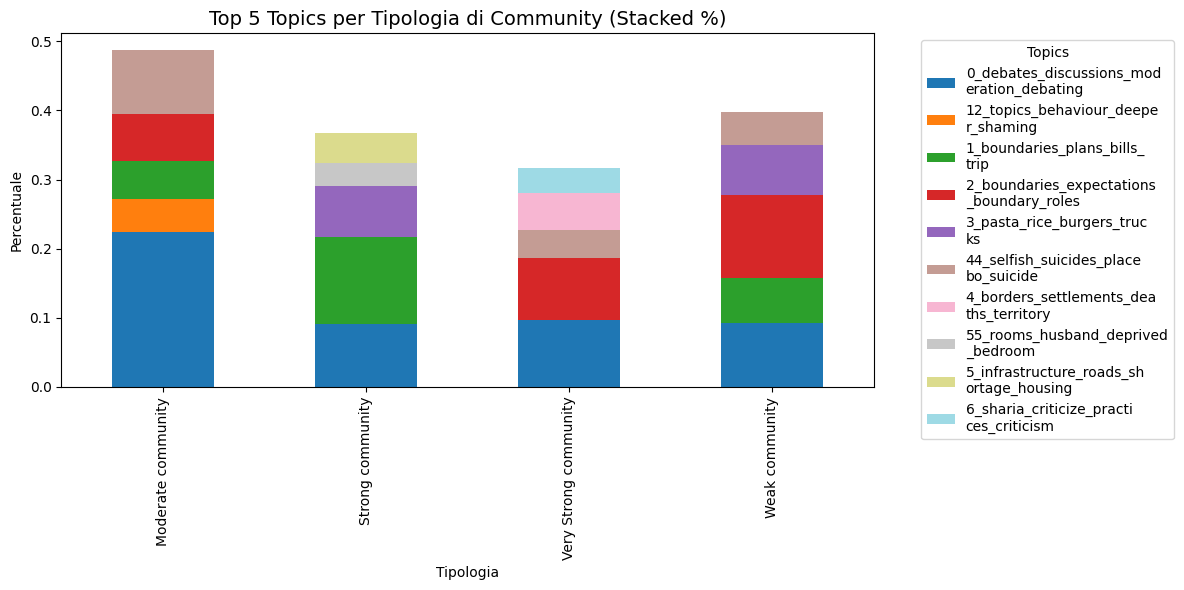

In [18]:
topic_freq_by_type = community_topic_counts_with_type.groupby(
    ['community_type', 'topic']
)['count'].sum().reset_index()

# Normalizza per tipologia
total_by_type = topic_freq_by_type.groupby('community_type')['count'].transform('sum')
topic_freq_by_type['percent'] = topic_freq_by_type['count'] / total_by_type

# Top 5 topic per ogni tipologia
top_topics_by_type = topic_freq_by_type.groupby('community_type').apply(
    lambda x: x.nlargest(5, 'percent')
).reset_index(drop=True)

# Wrap dei nomi dei topic (per leggibilità)
top_topics_by_type['topic_wrapped'] = top_topics_by_type['topic'].apply(
    lambda x: "\n".join(textwrap.wrap(x, 25))
)

# Grafico stacked bar
pivot_df = top_topics_by_type.pivot(
    index='community_type',
    columns='topic_wrapped',
    values='percent'
).fillna(0)

pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap="tab20"
)

plt.title("Top 5 Topics per Tipologia di Community (Stacked %)", fontsize=14)
plt.xlabel("Tipologia")
plt.ylabel("Percentuale")
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

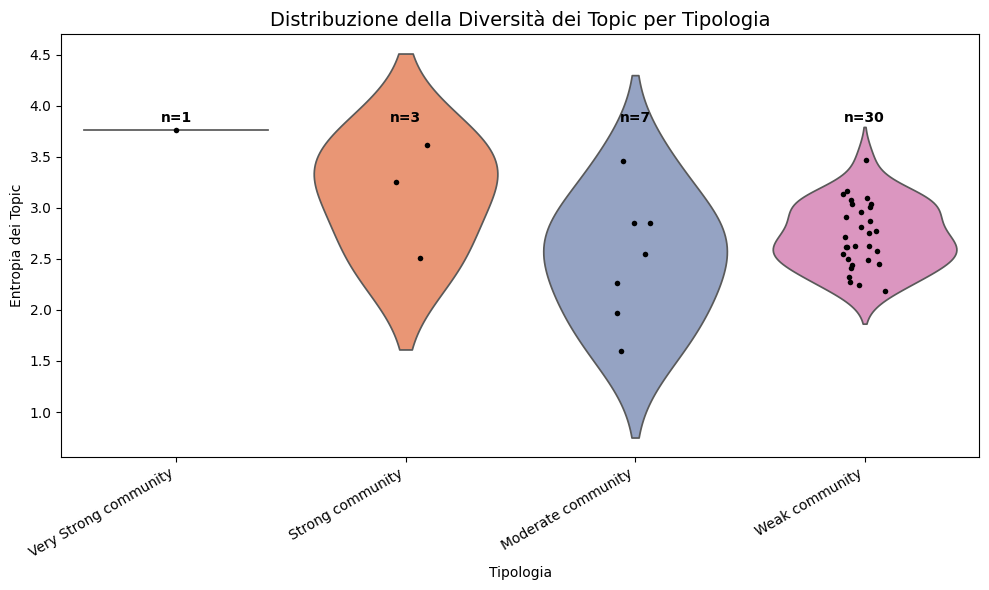

In [26]:
topic_diversity = community_topic_counts_with_type.groupby('community_id').agg({
    'count': lambda x: entropy(x/x.sum()),
    'community_type': 'first'
}).reset_index().rename(columns={'count': 'topic_entropy'})

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=topic_diversity,
    hue='community_type',
    x='community_type',
    y='topic_entropy',
    palette="Set2",
    inner=None
)

sns.stripplot(
    data=topic_diversity,
    x='community_type',
    y='topic_entropy',
    color="black",
    size=4,
    jitter=True
)

# --- Annotazioni: numero di community per tipologia ---
counts = topic_diversity.groupby('community_type')['community_id'].nunique()

# Recupera ordine effettivo delle categorie sull’asse X
order = topic_diversity['community_type'].unique()

for i, ct in enumerate(order):
    n = counts.get(ct, 0)
    plt.text(
        i,
        topic_diversity['topic_entropy'].max() + 0.05,
        f"n={n}",
        ha='center', va='bottom', fontsize=10, fontweight="bold"
    )

plt.title("Distribuzione della Diversità dei Topic per Tipologia", fontsize=14)
plt.xlabel("Tipologia")
plt.ylabel("Entropia dei Topic")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

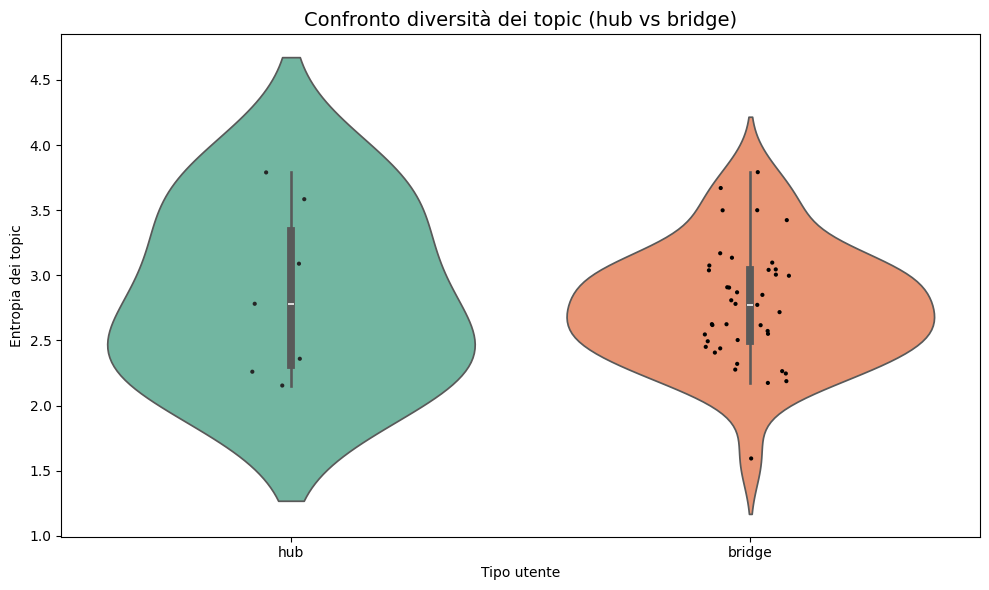

In [33]:
def plot_entropy_comparison(df, user_type):
    topic_div = df.groupby('community_id').agg({
        'count': lambda x: entropy(x / x.sum())
    }).reset_index().rename(columns={'count':'topic_entropy'})
    topic_div['user_type'] = user_type
    return topic_div

# Esempio con due dataset separati: hub_df, bridge_df
hub_entropy = plot_entropy_comparison(hub_topic_counts, "hub")
bridge_entropy = plot_entropy_comparison(bridge_topic_counts, "bridge")

entropy_all = pd.concat([hub_entropy, bridge_entropy])

plt.figure(figsize=(10,6))
sns.violinplot(
    data=entropy_all,
    hue='user_type',
    x='user_type',
    y='topic_entropy',
    palette="Set2"
)
sns.stripplot(
    data=entropy_all,
    hue='user_type',
    x='user_type',
    y='topic_entropy',
    palette="dark:black", size=3, jitter=True
)
plt.title("Confronto diversità dei topic (hub vs bridge)", fontsize=14)
plt.ylabel("Entropia dei topic")
plt.xlabel("Tipo utente")
plt.tight_layout()
plt.show()